In [1]:
import numpy as np
import pandas as pd
from ratings_graph import RatingsGraph
from baseline_debiaser import *
import matplotlib.pyplot as plt

## Working Synthetic Data

In [ ]:
# Working 2x2 example of synthetic dataset

# num_users, num_entities = 100, 50

# ground_truth_ratings = np.zeros(num_entities)
# ground_truth_ratings[type_1_entities] = 0.3
# ground_truth_ratings[np.logical_not(type_1_entities)] = 0.7

# ratings_matrix = np.zeros((num_users, num_entities))
# ratings_matrix[type_A_users[:, None].dot(type_1_entities[None, :])] = 0.6
# ratings_matrix[type_A_users[:, None].dot(np.logical_not(type_1_entities)[None, :])] = 1
# ratings_matrix[np.logical_not(type_A_users)[:, None].dot(type_1_entities[None, :])] = 0.1
# ratings_matrix[np.logical_not(type_A_users)[:, None].dot(np.logical_not(type_1_entities)[None, :])] = 0.5

In [2]:
def gen_ratings_graph(rating_sparseness, user_type_counts, entity_type_counts, ground_truth_fn, user_type_ratings, similarity_fn):
    '''
    rating_sparseness: percentage of ratings actually present
    user_types_prob: probability that user is type A vs B
    movie_type_prob: probability that movie is type 1 vs 2
    ground_truth: 2x1 matrix, ground truth each type movie
    user_biases: 2x2 matrix with user bias for each movie type
    '''
    num_users, num_entities = np.sum(user_type_counts), np.sum(entity_type_counts)
    ratings_graph = np.random.rand(num_users, num_entities) <= rating_sparseness #0.4
    
    user_types = np.random.permutation(np.repeat(np.arange(user_type_counts.shape[0]), user_type_counts))
    entity_types = np.random.permutation(np.repeat(np.arange(entity_type_counts.shape[0]), entity_type_counts))
    
    ground_truth_ratings = np.vectorize(ground_truth_fn)(entity_types)
    
    ratings_matrix = np.zeros((num_users, num_entities))
    for user in range(num_users):
        for entity in range(num_entities):
            ratings_matrix[user, entity] = user_type_ratings(user_types[user], entity_types[entity])

    similarity_matrix = np.zeros((num_entities, num_entities))
    for entity in range(num_entities):
        for entity_2 in range(entity, num_entities):
            similarity_matrix[entity, entity_2] = similarity_fn(entity_types[entity], entity_types[entity_2])
            similarity_matrix[entity_2, entity] = similarity_matrix[entity, entity_2] 
            
    return ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types, similarity_matrix

In [3]:
def get_median_error(ratings_matrix, ratings_graph, ground_truth_ratings):
    ratings_matrix_na = ratings_matrix.copy()
    ratings_matrix_na[ratings_graph==0]=np.nan
    median_pred = np.nanmedian(ratings_matrix_na, axis=0)
    return np.sqrt(np.mean((median_pred - ground_truth_ratings)**2))

In [4]:
def ground_truth_rating_fn(entity_type):
    return 0.6 if entity_type == 1 else 0.3

def user_type_rating_fn(user_type, entity_type):
    if user_type == 0:
        return ground_truth_rating_fn(entity_type) + 0.4
    else:
        return ground_truth_rating_fn(entity_type) - 0.1

def similarity_fn(e1,e2):
    return 1 if e1==e2 else 0

ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types, sim = gen_ratings_graph(0.4, \
                                                                        (100*np.array([0.5, 0.5])).astype(int), \
                                                                        (50*np.array([0.5, 0.5])).astype(int), \
                                                                        ground_truth_rating_fn,
                                                                        user_type_rating_fn, similarity_fn)
synthetic_graph = RatingsGraph(ratings_graph, ratings_matrix, entity_sim = sim, ground_truth_ratings=ground_truth_ratings)
biases, true_ratings, errors = debias_ratings_baseline(synthetic_graph, 0.99, 1.00, 200000, 0.01)
print(len(errors))
biases_no_moment, true_ratings_no_moment, errors_no_moment = debias_ratings_baseline(synthetic_graph, 0.99, 1.00, 200000, 1)

1150


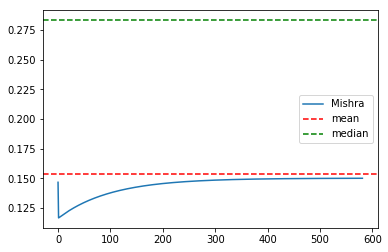

In [8]:
mean_pred = np.sum(ratings_matrix*ratings_graph, axis=0)/synthetic_graph.get_entity_rating_counts()
mean_pred_error = np.sqrt(np.mean((mean_pred - ground_truth_ratings)**2))

median_pred_error = get_median_error(ratings_matrix, ratings_graph, ground_truth_ratings)

#plt.plot(errors, label='Mishra + momentum')
plt.plot(errors_no_moment, label='Mishra')
#plt.plot(errors_type_bias, label='Type Specific Bias')
plt.axhline(mean_pred_error, color='r', linestyle='--', label='mean')
plt.axhline(median_pred_error, color='g', linestyle='--', label='median')
plt.legend()
plt.savefig('mishra_only.pdf')
plt.show()

In [ ]:
print mean_pred[:10]
print median_pred[:10]
best_iter = np.argmin(errors)
#true_ratings[best_iter]
#print(best_iter)
#np.sort(np.abs(biases[best_iter - 1] - biases[best_iter]))
print true_ratings[-1][:10]

In [ ]:
ground_truth_ratings[:10]

In [ ]:
plt.plot([np.max(np.absolute(bias)) for bias in biases])
plt.show()

In [ ]:
np.max(np.absolute(biases[-1]))

In [ ]:
[(user_types[i]+1, bias) for i, bias in enumerate(biases[-1])][:10]

In [ ]:
sim

## Synthetic Dataset 2 

In [ ]:
def ground_truth_rating_fn(entity_type):
    return 0.7 if entity_type == 1 else 0.3

def user_type_rating_fn(user_type, entity_type):
    if user_type == 0 and entity_type == 0:
        return 1
    if user_type == 0 and entity_type == 1:
        return 0
    if user_type == 1 and entity_type == 0:
        return 0.4
    else:
        return 0.6

def similarity_fn(e1,e2):
    return 1 if e1==e2 else 0

ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types, sim = gen_ratings_graph(1, \
                                                                        (100*np.array([0.5, 0.5])).astype(int), \
                                                                        (50*np.array([0.5, 0.5])).astype(int), \
                                                                        ground_truth_rating_fn,
                                                                        user_type_rating_fn, similarity_fn)
synthetic_graph = RatingsGraph(ratings_graph, ratings_matrix, entity_sim = sim, ground_truth_ratings=ground_truth_ratings)
biases, true_ratings, errors = debias_ratings_baseline(synthetic_graph, 0.99, 1.00, 200000, 0.01)
print(len(errors))
biases_no_moment, true_ratings_no_moment, errors_no_moment = debias_ratings_baseline(synthetic_graph, 0.99, 1.00, 200000, 1)
biases_type_bias, true_ratings_type_bias, errors_type_bias = \
    debias_ratings_baseline(synthetic_graph, 0.99, 1.0, 200000, 0.05,user_entity_specific=True)
print(len(errors_type_bias))

In [ ]:
mean_pred = np.sum(ratings_matrix*ratings_graph, axis=0)/synthetic_graph.get_entity_rating_counts()
mean_pred_error = np.sqrt(np.mean((mean_pred - ground_truth_ratings)**2))

median_pred_error = get_median_error(ratings_matrix, ratings_graph, ground_truth_ratings)

plt.plot(errors, label='Mishra + momentum')
plt.plot(errors_no_moment, label='Mishra')
plt.plot(errors_type_bias, label='Type Specific Bias')
plt.axhline(mean_pred_error, color='r', linestyle='--', label='mean')
plt.axhline(median_pred_error, color='g', linestyle='--', label='median')
plt.legend()
plt.savefig('mishra_synthetic_dataset2.pdf')
plt.show()

## Synthetic Data 3

In [ ]:
def ground_truth_rating_fn(entity_type):
    # uniform!
    return np.random.beta(10,10)

def user_type_rating_fn(user_type, entity_type):
    #np.random.seed(np.random.randint(0,10))
    # user and item of same type
    alpha_same, beta_same = 50, 5
    alpha_diff, beta_diff = 15, 30
    if user_type == entity_type:
        return np.random.beta(alpha_same, beta_same)
    else:
        return np.random.beta(alpha_diff, beta_diff)

def similarity_fn(entity_type_1, entity_type_2):
    alpha_same, beta_same = 50, 10
    alpha_diff, beta_diff = 12, 55
    if entity_type_1 == entity_type_2:
        return np.random.beta(alpha_same, beta_same)
    else:
        return np.random.beta(alpha_diff, beta_diff)
    
ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types, similarity = gen_ratings_graph(1.0, \
                                                                        (100*np.array([0.5, 0.5])).astype(int), \
                                                                        (60*np.array([0.5, 0.5])).astype(int), \
                                                                        ground_truth_rating_fn,
                                                                        user_type_rating_fn,
                                                                        similarity_fn)

In [ ]:
synthetic_graph = RatingsGraph(ratings_graph, ratings_matrix, 
                               entity_sim = similarity, ground_truth_ratings=ground_truth_ratings)
weights, ratings = similarity_weights_approach(synthetic_graph)

In [ ]:
print (ratings_matrix*ratings_graph)[0,:10]
print weights[0,:10]
print ratings[:10]
print ground_truth_ratings[:10]

In [ ]:
rmse = np.sqrt(np.mean((ratings - ground_truth_ratings)**2))
print rmse

In [ ]:
mean_pred = np.sum(ratings_matrix*ratings_graph, axis=0)/synthetic_graph.get_entity_rating_counts()
mean_pred_error = np.sqrt(np.mean((mean_pred - ground_truth_ratings)**2))

In [ ]:
mean_pred_error

In [ ]:
biases, true_ratings, errors = debias_ratings_baseline(synthetic_graph, 0.99, 1.00, 1000, 0.01)
errors[-1]

In [ ]:
biases_type_bias, true_ratings_type_bias, errors_type_bias = \
    debias_ratings_baseline(synthetic_graph, 0.99, 1.0, 200000, 0.05,user_entity_specific=True)
print(errors_type_bias[-1])

In [ ]:
median_pred_error = get_median_error(ratings_matrix, ratings_graph, ground_truth_ratings)
median_pred_error